# SHACL Simple

Ocean Info Hub SHACL validation examples

It should be noted here that SHACL validation is not a service OIH offers.  Rather, 
the validation is a capacity that the OIH architectural approach facilities.  Further
this validation follows W3C recommendations as describted in 
[https://www.w3.org/TR/shacl/](https://www.w3.org/TR/shacl/).

* [SHACL Playground](https://shacl.org/playground/)
* [kglab SHACL validation with pySHACL](https://derwen.ai/docs/kgl/ex5_0/)


## A few imports to support the code following

In [75]:
import kglab
from rdflib import Graph, plugin
from rdflib.serializer import Serializer
import pandas as pd
import seaborn as sns
from rdflib import Graph  #, plugin

# pyshack sends output to log along with the vars.  This suppresses that
import logging, sys
logging.disable(sys.maxsize)

## Load out files

The process involves two inputs.  One is the "data graph" which will be the graph we are testing.  The other in the "shape graph" which is the graph containing our validation and constraint logic.  Both of these are RDF based but can be in any serialization.  

Here we have used JSON-LD for the data graph, since that is what people are using to publish structured data on the web at their web sites, so lets stick with that.

For the shape graph, we use Turtle (.ttl) because it's cleaner, compact and a bit more friendly for human reading.  Since this graph is being built by humans for computers, lets cater to the human in that equation.

In [88]:
namespaces = {
    "shacl":   "http://www.w3.org/ns/shacl#" ,
    }

kg = kglab.KnowledgeGraph(
    name = "Schema.org based datagraph",
    base_uri = "https://example.org/id/",
    namespaces = namespaces,
    )

In [91]:
# set up dg array and the shape files (sg) we will test
dg = [ "./datagraphs/full.jsonld"]  # "./datagraphs/full.jsonld",
sg = './shapes/soso_common_v1.2.3.ttl'

In [92]:
for fn in dg:
          # kg.load_jsonld(fn.read().decode("utf-8", "ignore").replace('\n',' '))
          # kg.load_jsonld(fn)
          g = Graph().parse(fn, format='json-ld')
          result = g.serialize(format='ttl')# .decode('utf-8')
          # print(g.serialize(format='ttl'))
          kg.load_rdf_text(result)
    

conforms, report_graph, report_text = kg.validate(
    shacl_graph=sg,
    shacl_graph_format="ttl"
)


kg.load_rdf_text(data=report_graph.save_rdf_text(), format="ttl")



Checking 7 objects in soso
severity                                            sh:Violation
message                                                         
Expecting SO namespace of <http://schema.org/> ...             1


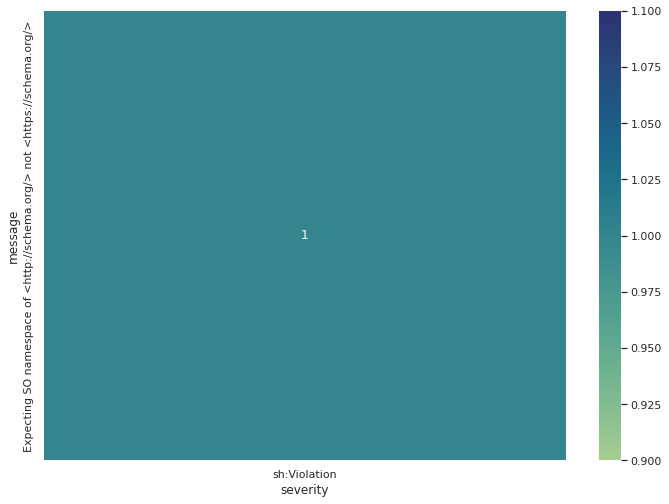

In [93]:
sparql = """
SELECT ?path ?value ?constraint ?severity ?message ?id ?focus
  WHERE {
    ?id rdf:type shacl:ValidationResult .
    ?id shacl:focusNode ?focus .
    ?id shacl:resultMessage ?message .
    ?id shacl:resultSeverity ?severity .
    ?id shacl:sourceConstraintComponent ?constraint .
    OPTIONAL {
        ?id shacl:resultPath ?path .
    }
    OPTIONAL {
        ?id shacl:value ?value .
    }
  }
"""

pdf = kg.query_as_df(sparql)
df = pdf  #.to_pandas()
df.style.background_gradient(cmap='Blues')

if 'severity' in df.columns:
    dfc = df.groupby('severity').count().reset_index().rename(columns={'path': 'Count'})
    ctst = pd.crosstab(df['message'], df['severity'],  margins = False , margins_name = 'Totals')

    print("Checking {} objects in {}".format(len("source:"),"soso" ))
    print(ctst)

    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.heatmap(ctst, annot=True, fmt=".0f", cmap = sns.cm.crest)
else:
    print("No severity column found, all SHACL validations passed")

In [80]:
df.to_csv("./output/validationReport.csv")